In [1]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf

In [2]:
!sed -i 's/# Download FTP/url = url.replace("people.eecs.berkeley.edu\/~taesung_park\/CycleGAN\/datasets", "efrosgans.eecs.berkeley.edu\/cyclegan\/datasets") # Download FTP/' /usr/local/lib/python3.10/dist-packages/tensorflow_datasets/core/download/downloader.py

In [3]:
import tensorflow_datasets as tfds

In [4]:
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fatal: destination path 'examples' already exists and is not an empty directory.


In [5]:
tf.random.set_seed(789)

# Download dataset
https://www.tensorflow.org/datasets/catalog/cycle_gan

In [6]:
dataset, metadata = tfds.load('cycle_gan/apple2orange', with_info = True, as_supervised=True)

In [7]:
train_a, train_b = dataset['trainA'], dataset['trainB']
test_a, test_b = dataset['testA'], dataset['testB']

In [8]:
qtd_train = len(train_a)
qtd_train

995

In [9]:
buffer_size = qtd_train
batch_size = 1
img_altura = 256
img_largura = 256

### Pré processamento das imagens para utilização da CycleGAN
- Recomendações do paper do CycleGAN ([link aqui](https://arxiv.org/pdf/1703.10593.pdf))

* No jitter aleatório, a imagem é redimensionada para 286x286, realizado o crop aleatório para pegar uma região 256x256 da imagem.

* Em espelhamento aleatório, a imagem é espelhada horizontalmente (esquerda / direita) de modo aleatório.

#### Random Crop:
- consiste em recortar aleatoriamente uma região da imagem original. Isso força o modelo a focar em diferentes partes da imagem em cada iteração, evitando que ele memorize apenas regiões específicas ou detalhes fixos.

In [10]:
def random_crop(img):
  img_crop = tf.image.random_crop(img, size=[img_altura, img_largura, 3])
  return img_crop

#### Normalização dos pixels para a escala -1 e 1

In [11]:
def normalize(img):
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  return img

#### Random jitter:
- envolve alterações sutis (ou não tão sutis) nos valores de pixels, como mudar ligeiramente a cor, brilho ou contraste. Esse “tremor” (jitter) de valores ajuda o modelo a ser mais robusto a variações nas condições de iluminação ou diferenças de câmera, por exemplo.

In [12]:
def random_jitter(img):
  img = tf.image.resize(img, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = random_crop(img)
  img = tf.image.random_flip_left_right(img)
  return img

In [13]:
def process_img_train(img, label):
  img = random_jitter(img)
  img = normalize(img)
  return img

In [14]:
def process_img_test(img, label):
  img = normalize(img)
  return img

### Carregando Dataset
- train_a/test_a: Maçãs
-train_b/test_b: Laranjas

In [15]:
train_a = train_a.cache().map(process_img_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
train_b = train_b.cache().map(process_img_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
test_a = test_a.cache().map(process_img_test, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
test_b = test_b.cache().map(process_img_test, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)

In [16]:
amostra_a = next(iter(train_a))
amostra_b = next(iter(train_b))

Maçã com jitter aleatório:


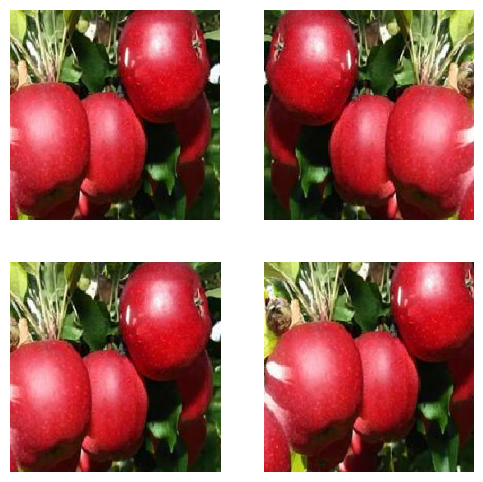

In [17]:
print("Maçã com jitter aleatório:")
plt.figure(figsize = (6, 6))
for i in range(4):
  a_jitter = random_jitter(amostra_a[0])
  plt.subplot(2, 2, i + 1)
  plt.imshow(a_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

Laranja com jitter aleatório:


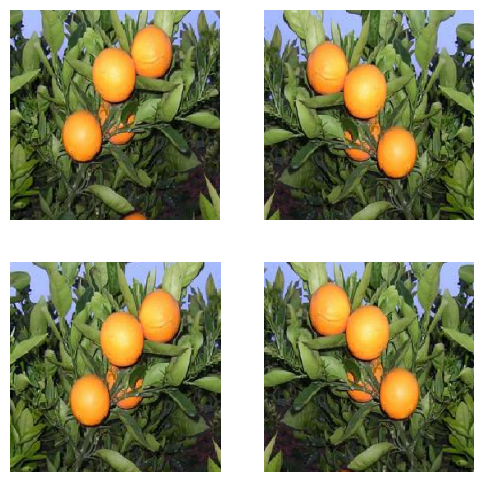

In [18]:
print("Laranja com jitter aleatório:")
plt.figure(figsize = (6, 6))
for i in range(4):
  a_jitter = random_jitter(amostra_b[0])
  plt.subplot(2, 2, i + 1)
  plt.imshow(a_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

## Gerador e Discriminador
1. O CycleGAN do paper utiliza *instance normalization* ao invés de *batch normalization*
2. O Gerador usado é uma resnet modificada, já aqui usaremos uma U-net para tornar o processo mais simples e prático


In [19]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

canais_saida = 3
gerador_g = pix2pix.unet_generator(canais_saida, norm_type='instancenorm')
gerador_f = pix2pix.unet_generator(canais_saida, norm_type = 'instancenorm')
discriminador_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminador_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Algoritmo por trás do CycleGAN:

* Há 2 geradores (G e F) e 2 discriminadores (X e Y) sendo treinados:

1. Gerador G = aprende a transformar imagem X para imagem Y  (`G:X->Y`)
2. Gerador F = aprende a transformar imagem Y para imagem X  (`G:Y->X`)
3. Discriminador D_X = aprende a diferenciar imagem X e a imagem X gerada (`X(F(Y))`)
4. Discriminador D_Y = aprende a diferenciar imagem Y e a imagem Y gerada (`Y(G(X))`)

### Visualização
- Visualização sem treinar antes, resultado será ruim

<Figure size 800x800 with 0 Axes>

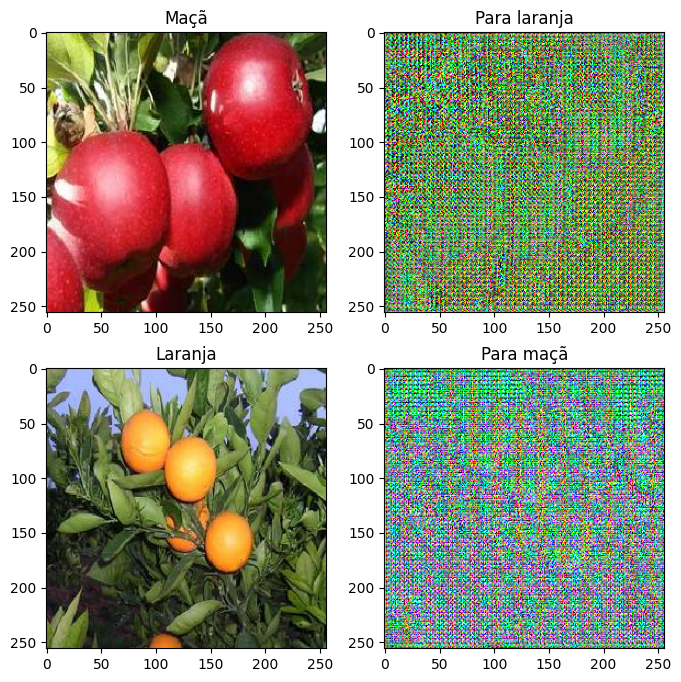

In [20]:
b_gerada = gerador_g(amostra_a)
a_gerada = gerador_f(amostra_b)
plt.figure(figsize=(8, 8))
plt.figure(figsize=(8,8))
imgs = [amostra_a, b_gerada, amostra_b, a_gerada]
titulo = ['Maçã', 'Para laranja', 'Laranja', 'Para maçã']
for i in range(len(imgs)):
  plt.subplot(2, 2, i + 1)
  plt.title(titulo[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * 6 + 0.5)
plt.show()

## Loss Functions
* Diferente do Pix2Pix, com o CycleGAN não temos um conjunto de treinamento pareado, portanto não há uma garantia de que a imagem de entrada x e a imagem de referência y estejam semelhantes de algum modo.

* Para garantir que a rede aprenda a fazer o mapeamento correto, os autores propuseram uma perda de consistência cíclica (*cycle consistency loss*)


In [21]:
lambda_ = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def loss_discriminator(real, gerada):
  loss_real = loss(tf.ones_like(real), real)
  loss_gerada = loss(tf.zeros_like(gerada), gerada)
  d_loss_total = loss_real + loss_gerada
  return d_loss_total

def loss_gerador (gerada):
  return loss(tf.ones_like(gerada), gerada)

### Cycle consistency loss:
Cycle Consistency Loss é uma função de perda que garante que, se você traduzir uma imagem do domínio \( X \) para o domínio \( Y \) e depois traduzir de volta para o domínio \( X \), o resultado deve ser semelhante à imagem original. Em outras palavras, o ciclo de tradução deve ser consistente

#### Como funciona?

1. **Tradução Direta e Reversa:**
   - Seja \( G \) o gerador que mapeia imagens do domínio \( X \) para o domínio \( Y \).
   - Seja \( F \) o gerador que mapeia imagens do domínio \( Y \) para o domínio \( X \).
   - Para uma imagem \( x \) do domínio \( X \):
     - \( G(x) \) gera uma imagem no domínio \( Y \).
     - \( F(G(x)) \) deve reconstruir a imagem original \( x \).

2. **Cálculo da Perda:**
   - A Cycle Consistency Loss é calculada como a diferença entre a imagem original e a imagem reconstruída após o ciclo de tradução.
   - Para o domínio \( X \), a perda é:
     
     \{cycle\_consistency\_loss}_X = \| F(G(x)) - x \|
     
   - Para o domínio \( Y \), a perda é:
     
     \{cycle\_consistency\_loss}_Y = \| G(F(y)) - y \|
     
   - A perda total é a soma das duas perdas:
     
     \{cycle\_consistency\_loss} = {cycle\_consistency\_loss}_X + {cycle\_consistency\_loss}_Y
     

In [22]:
def cycle_loss(img_real, img_cycled):
  loss1 = tf.reduce_mean(tf.abs(img_real - img_cycled))
  return lambda_ * loss1

In [23]:
def identity_loss(img_real, img_igual):
  loss = tf.reduce_mean(tf.abs(img_real - img_igual))
  return lambda_ * 0.5 * loss

## Optimizers

In [24]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999

gerador_g_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
gerador_f_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
discriminador_x_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
discriminador_y_optimizer = tf.keras.optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)

In [25]:
checkpoint_dir = "./checkpoints/train"
checkpoint = tf.train.Checkpoint(generator_g = gerador_g,
                                 generator_f = gerador_f,
                                 discriminator_x = discriminador_x,
                                 discriminator_y = discriminador_y,
                                 generator_g_optimizer=gerador_g_optimizer,
                                 generator_f_optimizer = gerador_f_optimizer,
                                 discriminator_x_optimizer = discriminador_x_optimizer,
                                 discriminator_y_optimizer = discriminador_y_optimizer)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoint)
  print('Restaurado para o último checkpoint!')

## Função para realizar o treinamento

In [26]:
epochs = 10
def gerar_img(modelo, teste_entrada):
  gerada = modelo(teste_entrada)
  plt.figure(figsize=(8, 8))
  lista_imgs = [teste_entrada[0], gerada[0]]
  titulo = ['Imagem Entrada', 'Imagem Gerada']
  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(titulo[i])
    if i == 0:
      plt.imshow(lista_imgs[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

In [27]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    fake_y = gerador_g(real_x, training=True)
    cycled_x = gerador_f(fake_y, training=True)

    fake_x = gerador_f(real_y, training=True)
    cycled_y = gerador_g(fake_x, training=True)

    igual_x = gerador_f(real_x, training=True)
    igual_y = gerador_g(real_y, training=True)
    #saida do discriminador
    disc_real_x = discriminador_x(real_x, training=True)
    disc_fake_x = discriminador_x(fake_x, training=True)

    disc_real_y = discriminador_y(real_y, training=True)
    disc_fake_y = discriminador_y(fake_y, training=True)
    #loss functions
    gerador_g_loss = loss_gerador(disc_fake_y)
    gerador_f_loss = loss_gerador(disc_fake_x)
    cycle_loss_total = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
    total_gerador_g_loss = gerador_g_loss + cycle_loss_total + identity_loss(real_y, igual_y)
    total_gerador_f_loss = gerador_f_loss + cycle_loss_total + identity_loss(real_x, igual_x)
    discriminador_x_loss = loss_discriminator(disc_real_x, disc_fake_x)
    discriminador_y_loss = loss_discriminator(disc_real_y, disc_fake_y)
      # Calcula os gradients para gerador e discriminador
  gerador_g_gradients = tape.gradient(total_gerador_g_loss, gerador_g.trainable_variables)
  gerador_f_gradients = tape.gradient(total_gerador_f_loss, gerador_f.trainable_variables)
  discriminador_x_gradients = tape.gradient(discriminador_x_loss, discriminador_x.trainable_variables)
  discriminador_y_gradients = tape.gradient(discriminador_y_loss, discriminador_y.trainable_variables)

  # Aplica os gradients para o optimizer
  gerador_g_optimizer.apply_gradients(zip(gerador_g_gradients, gerador_g.trainable_variables))
  gerador_f_optimizer.apply_gradients(zip(gerador_f_gradients, gerador_f.trainable_variables))
  discriminador_x_optimizer.apply_gradients(zip(discriminador_x_gradients, discriminador_x.trainable_variables))
  discriminador_y_optimizer.apply_gradients(zip(discriminador_y_gradients, discriminador_y.trainable_variables))

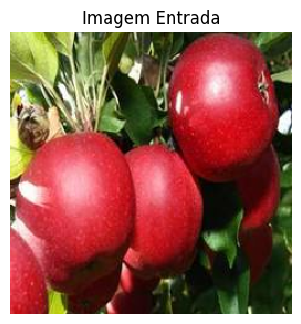

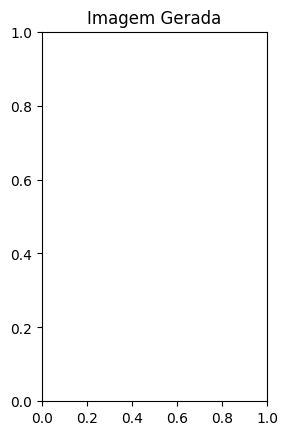

Tempo levado para época 10: 469.6168055534363 segundos

Checkpoint salvo


In [28]:
def treinar(train_a, train_b, gerador_g, etapas):
  for epoch in range(epochs):
    inicio = time.time()

    n = 0
    for img_x, img_y in tf.data.Dataset.zip((train_a, train_b)):
      train_step(img_x, img_y)
      if n % 10 == 0:
        print('.', end = '')
      n += 1

    clear_output(wait = True)
    gerar_img(gerador_g, amostra_a)
    print('Tempo levado para época {}: {} segundos\n'.format(epoch + 1, time.time() - inicio))

    if (epoch + 1) % 5 == 0:
      checkpoint_dir_salvo = checkpoint_manager.save()
      print('Checkpoint salvo')

    gerador_g.save_weights('modelo_cyclegan.weights.h5')

treinar(train_a, train_b, gerador_g, epochs)